# Working With Keras: Deep dive

Three different APIs for building models in Keras:
* Sequential Model: most approachable, basically a Python list. limited to simple stacks of layers
* Functional API: focuses on graph-like model architectures. Represents a nice mid-point between usability and flexibility, most commonly used model-building API.
* Model subclassing: low-level option where you write everything from scratch. Ideal if want full control over everything. However, won't get acess to many built-in Keras features, more error-prone.

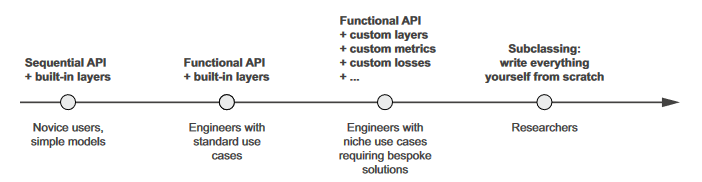

## The Sequential Model

Simplest way to build Keras model

In [1]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

Possible to build the same model incrementally using add()

In [2]:
model = keras.Sequential()
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

Layers only get built when are called the first time, this is because the shape of the layers' weights depends on the shape of their input: until the input shape is known, they can't be created.
The preceding Sequential model does not have any weights until you call it on some data, or call its build() method with an input shape

In [3]:
model.weights

ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [4]:
model.build((None,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


When building incrementally a Sequential model, it is useful to be able to print a summary of what the current model looks like after adding each layer. But you can't print a summary until the model is built!
There is a way to have the Sequential model built on the fly, just declare the shape of the model's inputs in advance, via the Input class.

In [5]:
model = keras.Sequential()
model.add(layers.Input(shape=(3,)))
model.add(layers.Dense(64,activation='relu'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.add(layers.Dense(10,activation='relu'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


Common debugging workflow when dealing with layers that transform inputs in complex ways, such as the convolutional layers.

## Functional API

Sequential model is easy to use but extremely limited, it can only express models with a single input and a single output, applying one layer after another.
In practice it's common to encounter model with multiple inputs, multiple outputs, or a nonlinear topology.
In such cases you'd build the model using the functional API. This is what most Keras models you'll encounter in the wild use.

In [7]:
inputs = keras.Input(shape=(3,), name='my_input')
features = layers.Dense(64,activation='relu')(inputs)
outputs = layers.Dense(10,activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

We started by declaring an Input:

inputs = kera.Input()

This input object holds info about the shape and dtype of the data the model will process

In [8]:
print(inputs.shape)
print(inputs.dtype)

(None, 3)
<dtype: 'float32'>


We call this object a symbolic tensor. It does not contain actual data, but it encodes the specifications of the actual tensors of data the model will see when you use it. It stand for future tensors of data.
Next, we created a layers and called it on the input:

features = layers.Dense()(inputs)

All Keras layers can be called both on real tensors and on symbolic tensors. In the latter case, tye return a new symbolic tensor, with updated shape and dtype

In [9]:
features.shape

TensorShape([None, 64])

After obtaining the final outputs, we instantiated the model by specifying its inputs and outputs in the Model constructor:

outputs = layers.Dense()(features)\
model = keras.Model()


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### Multi-Input and Multi-output Models
Most deep learning models don't look like lists, they look like graphs. For instance they may have multiple inputs or multiple outputs.
Let's say we buld a system to rank customer support tickets by priprity and route them to the appropriate department. Your model has three inputs:

* the title of the ticket (text input)
* the text body of the ticket (text input)
* the tags added by the user (categorical input)

We can encode the text inputs as arrays of ones and zeros of size vocabulary_size, the model will also have two outputs:

* the priority score of the ticket, scalar between 0 and 1 (sigmoid)
* the department that should handle the ticket (softmax)

In [11]:
vocabulary_size=10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name='title')
text_body = keras.Input(shape=(vocabulary_size, ), name="text_body")
tags = keras.Input(shape=(num_tags,), name='tags')

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation='relu')(features)

priority = layers.Dense(1, activation='sigmoid', name='priority')(features)
department = layers.Dense(num_departments, activation='softmax', name='department')(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority,department])

### Training multi-in multi-out model

You can train your model in much the same way you would train a Sequential one, by calling fit() with lists of input and output data. These lists of data should be in the same order as inputs passed in the Model constructor

In [12]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0,2, size=(num_samples,vocabulary_size))
text_body_data = np.random.randint(0,2, size=(num_samples,vocabulary_size))
tags_data = np.random.randint(0,2,size=(num_samples,num_tags))

priority_data = np.random.random(size=(num_samples,1))
department_data = np.random.randint(0,2,size=(num_samples,num_departments))

model.compile(optimizer='rmsprop',loss=['mean_squared_error','categorical_crossentropy'], metrics=[['mean_absolute_error'],['accuracy']])
model.fit([title_data,text_body_data,tags_data],[priority_data,department_data],epochs=1)
model.evaluate([title_data,text_body_data,tags_data],[priority_data,department_data])

40/40 [==============================] - 1s 7ms/step - loss: 28.9737 - priority_loss: 0.3475 - department_loss: 28.6262 - priority_mean_absolute_error: 0.5150 - department_accuracy: 0.2547


[28.973712921142578,
 0.3475225269794464,
 28.626190185546875,
 0.5149663686752319,
 0.25468748807907104]

If you don't want to rely on input order, you can also leverage the names given to the Input objects and the output layers, and pass the data via dictionaries

In [13]:
model.compile(optimizer="rmsprop",
    loss={"priority": "mean_squared_error", "department":
        "categorical_crossentropy"},
    metrics={"priority": ["mean_absolute_error"], "department":
        ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data,
    "tags": tags_data},
    {"priority": priority_data, "department": department_data},
    epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data,
    "tags": tags_data},
    {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 3ms/step


### Power of Functional API: Access to layer connectivity
Functional odel is an explicit graph data structure. this makes it possible to inspect how layers are connected and reuse previous graph nodes as part of new models. It also fits the mental model that most researchers use when thinking about a deep neural network: graph of layers.
This enables two important use cases: model visualization and feature extraction.
Let's visualize the connectivity of the model we defined. You can plot a functional model as a graph with the plot_model() utility

In [14]:
keras.utils.plot_model(model, 'ticket_classifier.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


You can add to this plot th einput and output shapes of each layer in the model, which can be hlpful during debugging

In [15]:
keras.utils.plot_model(model, 'ticket_classifier_with_shape_info.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


The "None" in the tensor shapes represents the batch size: this model allows batches of any size.
Access to layer connectivity also means that you can inspect and reuse individual nodes in the graph.
The model.layers model property provides the list of layers that make up the model, and for each layer you can query layer.input and layer.output

In [16]:
#Retireve ins and outs of a layer in functional model

print(model.layers)
print(model.layers[3].input)
print(model.layers[3].output)

[<keras.engine.input_layer.InputLayer object at 0x000001BF937EAE30>, <keras.engine.input_layer.InputLayer object at 0x000001BF93848940>, <keras.engine.input_layer.InputLayer object at 0x000001BF93848B20>, <keras.layers.merging.concatenate.Concatenate object at 0x000001BF93866740>, <keras.layers.core.dense.Dense object at 0x000001BF93866440>, <keras.layers.core.dense.Dense object at 0x000001BF938642B0>, <keras.layers.core.dense.Dense object at 0x000001BF938655A0>]
[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>, <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>, <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 20100), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


This enables to do feature extraction, creating models that reuse intermediate features from other models.

Let's say you want to add another output to the previous model, estimate how long a given issue ticket will take to resolve, a kind of difficult rating. You could do this via a classification layer over three categories: "quick", "medium" and "difficult".
You need to recreate and retrain a model from scratch. Start from the intermediate features of previous model, simce you have access to them.

In [17]:
#Create new model reusing intermediate layer outputs

features = model.layers[4].output
difficulty = layers.Dense(3,activation='softmax', name='difficulty')(features)

new_model = keras.Model(inputs=[title,text_body,tags],
                        outputs=[priority,department,difficulty])
keras.utils.plot_model(new_model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Subclassing the Model Class
The last model-building pattern is the most advanced one:
Model Subclassing:
* In the __init__() method, define the layers the model will use.
* In the call() method, define the forward pass of the model, reusing the layers previously created.
* Instantiate your subclass, and call it on data to create its weights

In [21]:
#Prev example as subclassed model

class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(num_departments, activation='softmax')

    def call(self, inputs):
        title=inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

Once the model is defined, you can instantiate it. This will only create its weights the first time you call it on some data

In [22]:
model = CustomerTicketModel(num_departments=4)
priority, department = model({'title':title_data,'text_body':text_body_data,'tags':tags_data})

The difference between a Layer subclass and a Model subclass is simple, a layer is a building block used to create models, and a model is the top-level object you train, export fot inference, etc..
In shoer, Model has fit(), evaluate(), and predict() methods. Layers don't. 
Apart from this, the two classes are virtually identical. You can compile and train a Model subclass like Sequential and Functional

In [23]:
model.compile(optimizer='rmsprop', loss=['mean_squared_error','categorical_crossentropy'], metrics=[['mean_absolute_error'],['accuracy']])
model.evaluate({'title':title_data, 'text_body':text_body_data, 'tags':tags_data}, [priority_data,department_data])
priority_preds, department_preds = model.predict({'title':title_data, 'text_body':text_body_data, 'tags':tags_data})

40/40 [==============================] - 0s 4ms/step


#### What Subclass Model does not support

You are responsible for most of the model logic, which means potential error surface is much larger. As a result you have more debugging work to do. Functional and subclassed models are substantially different. A Functional model is an explicit data structure, a graph of layers which you can view, inspect, and modify. A subclassed model is a piece of bytecode - Python class with a call() method that contains raw code. this is the source of sublcassing workflow's flexibility, you can code up whatever functionality you like, but introduces new limitations.
For instance, because the way layers are connected to each other is hidden inside the body of the call()
method, you cannot access that info. Calling summary() will not display layer connectivity, and you cannot plot the model topology via plot_model(). Likewise, if you have a subclassed model, you cannot access the nodes of the graph of layers to do feature extraction because there is simply no graph. Once instantiated, the forward pass becomes a black box.

## Mix and match different patterns

Choosing one of these patterns does not lock you out of the others. All models in the Keras API can smoothly interoperate with each other. They are all part of the same spectrum of workflows.

In [24]:
#Create Functional model including subclassed model

class Classifier(keras.Model):

    def __init__(self,num_classes=2):
        super().__init__()
        if num_classes==2:
            num_units = 1
            activation='sigmoids'
        else:
            num_units=num_classes
            activation='softmax'
        self.dense = layers.Dense(num_units,activation=activation)

    def call(self,inputs):
        return self.dense(inputs)
    

inputs = keras.Input(shape=(3,))
features = layers.Dense(64,activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
#Subclassed mdodel including functional model

inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1,activation='sigmoid')(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self,num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation='relu')
        self.classifier = binary_classifier

    def call(self,inputs):
        features = self.dense(inputs)
        return self.classifier(features)
    
model = MyModel()


## Use Built-In training and evaluation loops
There are a couple of ways to customize the training workflow:

* Provide custom metrics
* Pass callbacks to fit() to schedule actions to be take at specific points during training

### Write your own metrics
Metrics are key to measuring the performance of your model, commonly used metrics for classification and regression are already part of the built-in keras.metrics module. But, if you are doing anything out of the ordinary, you need to be able to write your own.
A Keras metric is a subclass of the keras.metrics.Metric class. Like layers, a metric has an internal state stored in TF variables. Unlike layers, these variables aren't updated via backpropagation, so you have to write the state-update logic which happens in the update_state() method.


In [ ]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name='rmse', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name='mse_sum', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros', dtype='int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true-t_pred))
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    #Return current value of metric
    def result(self):
        return tf.sqrt(self.mse_sum/ tf.cast(self.total_samples,tf.float32))
    
    #You need to expose a way to reset the metric state without having to reinstantiate it
    #this enables the same metric objects to be used across different epochs of training or both training and evaluation
    def reset_state(self):
        self.mse_sum.assign(0,)
        self.total_samples.assing(0)

    
model = get_mnist_model()
model.compile(optimizer="rmsprop",
loss="sparse_categorical_crossentropy",
metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
epochs=3,
validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
        

### Use callbacks
